Importing libraries

In [22]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.feature import hog
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [15]:
IMAGE_DIR = "augmented_images"  
IMAGE_SIZE = (224, 224)  # Standard size for CNN models
os.makedirs("features_image", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("outputs/plots", exist_ok=True)
os.makedirs("outputs/reports", exist_ok=True)

print("\n✓ Output directories created")
print(f"  - features_image/")
print(f"  - models/")
print(f"  - outputs/plots/")
print(f"  - outputs/reports/")




✓ Output directories created
  - features_image/
  - models/
  - outputs/plots/
  - outputs/reports/


Loading and Organising Images

In [16]:
# List all images
all_images = [f for f in os.listdir(IMAGE_DIR) if f.endswith('.jpg')]
print(f"✓ Found {len(all_images)} images")

# Extract unique team members
team_members = sorted(set([img.split('_')[0] for img in all_images]))
print(f"✓ Team members detected: {team_members}")

# Count images per person
print(f"\nImages per person:")
for member in team_members:
    count = sum(1 for img in all_images if img.startswith(member))
    print(f"  • {member}: {count} images")

# Show sample filenames
print(f"\nSample filenames:")
for i, img in enumerate(all_images[:5]):
    print(f"  {i+1}. {img}")


✓ Found 51 images
✓ Team members detected: ['Fidele', 'Irais', 'Kerie']

Images per person:
  • Fidele: 18 images
  • Irais: 18 images
  • Kerie: 15 images

Sample filenames:
  1. Fidele_neutral_gaussian_noise.jpg
  2. Fidele_neutral_grayscale.jpg
  3. Fidele_neutral_horizontal_flip.jpg
  4. Fidele_neutral_original.jpg
  5. Fidele_neutral_rotation.jpg


Extracting features using CNN

In [33]:
# STEP 4: FEATURE EXTRACTION FUNCTIONS
# ============================================
print("STEP 4: DEFINING FEATURE EXTRACTION FUNCTIONS")

def extract_hog_features(image):
    """Extract HOG (Histogram of Oriented Gradients) features"""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    features = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False
    )
    return features

def extract_color_histogram(image):
    """Extract color histogram features from RGB channels"""
    hist_r = cv2.calcHist([image], [0], None, [32], [0, 256]).flatten()
    hist_g = cv2.calcHist([image], [1], None, [32], [0, 256]).flatten()
    hist_b = cv2.calcHist([image], [2], None, [32], [0, 256]).flatten()
    
    color_hist = np.concatenate([hist_r, hist_g, hist_b])
    color_hist = color_hist / (color_hist.sum() + 1e-7)  # Normalize
    
    return color_hist

def extract_statistical_features(image):
    """Extract basic statistical features"""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    features = np.array([
        gray.mean(),
        gray.std(),
        np.median(gray),
        gray.min(),
        gray.max(),
        np.percentile(gray, 25),
        np.percentile(gray, 75)
    ])
    return features

def extract_combined_features(image):
    """Combine all feature extraction methods"""
    hog_feat = extract_hog_features(image)
    color_feat = extract_color_histogram(image)
    stat_feat = extract_statistical_features(image)
    
    return np.concatenate([hog_feat, color_feat, stat_feat])

print("✓ Feature extraction functions defined:")
print("  • HOG features (shape/structure)")
print("  • Color histograms (RGB)")
print("  • Statistical features (mean, std, etc.)")

# ============================================
# STEP 5: LOAD AND PROCESS ALL IMAGES
# ============================================
print("STEP 5: LOADING AND PROCESSING IMAGES")

features_list = []
labels_list = []
filenames_list = []

print(f"Processing {len(all_images)} images...")
print("This may take a few minutes...\n")

for idx, filename in enumerate(all_images):
    # Extract label (person name)
    person_name = filename.split('_')[0]
    
    # Load image
    img_path = os.path.join(IMAGE_DIR, filename)
    img = cv2.imread(img_path)
    
    if img is not None:
        # Resize and convert to RGB
        img_resized = cv2.resize(img, IMAGE_SIZE)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        
        # Extract features
        features = extract_combined_features(img_rgb)
        
        # Store
        features_list.append(features)
        labels_list.append(person_name)
        filenames_list.append(filename)
        
        # Progress update
        if (idx + 1) % 10 == 0:
            print(f"  Processed: {idx + 1}/{len(all_images)} images")
    else:
        print(f"  ⚠ Warning: Could not load {filename}")

# Final progress update
if len(all_images) % 10 != 0:
    print(f"  Processed: {len(all_images)}/{len(all_images)} images")

# Convert to numpy arrays
X = np.array(features_list)
y = np.array(labels_list)

print(f"\n✓ Processing complete!")
print(f"  Total samples: {X.shape[0]}")
print(f"  Feature vector size: {X.shape[1]}")
print(f"  Number of people: {len(np.unique(y))}")

# STEP 6: SAVE FEATURES TO CSV
print("STEP 6: SAVING FEATURES TO CSV")

# Create DataFrame
feature_columns = [f'feature_{i}' for i in range(X.shape[1])]
df_features = pd.DataFrame(X, columns=feature_columns)
df_features['person'] = y
df_features['filename'] = filenames_list

# Save to CSV
csv_path = "features_image/image_features.csv"
df_features.to_csv(csv_path, index=False)

print(f"✓ Features saved to: {csv_path}")
print(f"  Shape: {df_features.shape}")
print(f"\nFirst few rows:")
print(df_features[['person', 'filename', 'feature_0', 'feature_1', 'feature_2']].head())


STEP 4: DEFINING FEATURE EXTRACTION FUNCTIONS
✓ Feature extraction functions defined:
  • HOG features (shape/structure)
  • Color histograms (RGB)
  • Statistical features (mean, std, etc.)
STEP 5: LOADING AND PROCESSING IMAGES
Processing 51 images...
This may take a few minutes...

  Processed: 10/51 images
  Processed: 20/51 images
  Processed: 30/51 images
  Processed: 40/51 images
  Processed: 50/51 images
  Processed: 51/51 images

✓ Processing complete!
  Total samples: 51
  Feature vector size: 26347
  Number of people: 3
STEP 6: SAVING FEATURES TO CSV
✓ Features saved to: features_image/image_features.csv
  Shape: (51, 26349)

First few rows:
   person                            filename  feature_0  feature_1  feature_2
0  Fidele   Fidele_neutral_gaussian_noise.jpg   0.228677   0.185161   0.112485
1  Fidele        Fidele_neutral_grayscale.jpg   0.261648   0.000000   0.190182
2  Fidele  Fidele_neutral_horizontal_flip.jpg   0.227100   0.039062   0.148231
3  Fidele         Fidele

Prepare Data For Training

In [34]:
print("STEP 7: PREPARING DATA FOR TRAINING")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Label Encoding:")
for idx, name in enumerate(label_encoder.classes_):
    print(f"  {name} → {idx}")

# Split data (stratified to ensure each person in train and test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print(f"\nDataset Split:")
print(f"  Training set: {X_train.shape[0]} images ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
print(f"  Test set: {X_test.shape[0]} images ({X_test.shape[0]/X.shape[0]*100:.1f}%)")

# Verify split per person
print(f"\nPer-person split:")
for idx, name in enumerate(label_encoder.classes_):
    train_count = np.sum(y_train == idx)
    test_count = np.sum(y_test == idx)
    print(f"  {name}: {train_count} train, {test_count} test")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Features scaled (mean=0, std=1)")


STEP 7: PREPARING DATA FOR TRAINING
Label Encoding:
  Fidele → 0
  Irais → 1
  Kerie → 2

Dataset Split:
  Training set: 40 images (78.4%)
  Test set: 11 images (21.6%)

Per-person split:
  Fidele: 14 train, 4 test
  Irais: 14 train, 4 test
  Kerie: 12 train, 3 test

✓ Features scaled (mean=0, std=1)


Training the Face Recognition model

In [35]:
print("STEP 8: TRAINING RANDOM FOREST MODEL")

# Initialize model
model = RandomForestClassifier(
    n_estimators=150,
    max_depth=25,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

print("Model parameters:")
print(f"  • Number of trees: {model.n_estimators}")
print(f"  • Max depth: {model.max_depth}")

# Train model
print("\nTraining model...")
model.fit(X_train_scaled, y_train)
print("✓ Training complete!")


STEP 8: TRAINING RANDOM FOREST MODEL
Model parameters:
  • Number of trees: 150
  • Max depth: 25

Training model...
✓ Training complete!


Evaluating The Model

In [36]:
print("STEP 9: MODEL EVALUATION")

# Predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='weighted')
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy:     {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"F1-Score:          {test_f1:.4f}")
print("="*70)

# Classification Report
print("\nDetailed Classification Report:")
print("-"*70)
report = classification_report(
    y_test, y_pred_test,
    target_names=label_encoder.classes_,
    digits=4
)
print(report)

# Save report to file
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
report_path = f"outputs/reports/classification_report_{timestamp}.txt"
with open(report_path, 'w') as f:
    f.write("FACE RECOGNITION MODEL - CLASSIFICATION REPORT\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("="*70 + "\n\n")
    f.write(f"Training Accuracy: {train_accuracy:.4f}\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f}\n")
    f.write(f"F1-Score: {test_f1:.4f}\n\n")
    f.write(report)

print(f"\n✓ Report saved to: {report_path}")


STEP 9: MODEL EVALUATION
Training Accuracy: 1.0000 (100.00%)
Test Accuracy:     1.0000 (100.00%)
F1-Score:          1.0000

Detailed Classification Report:
----------------------------------------------------------------------
              precision    recall  f1-score   support

      Fidele     1.0000    1.0000    1.0000         4
       Irais     1.0000    1.0000    1.0000         4
       Kerie     1.0000    1.0000    1.0000         3

    accuracy                         1.0000        11
   macro avg     1.0000    1.0000    1.0000        11
weighted avg     1.0000    1.0000    1.0000        11


✓ Report saved to: outputs/reports/classification_report_20251114_190817.txt


Visualisaation

Confusion Matrix


STEP 10: GENERATING CONFUSION MATRIX
✓ Confusion matrix saved to: outputs/plots/confusion_matrix_20251114_185819.png


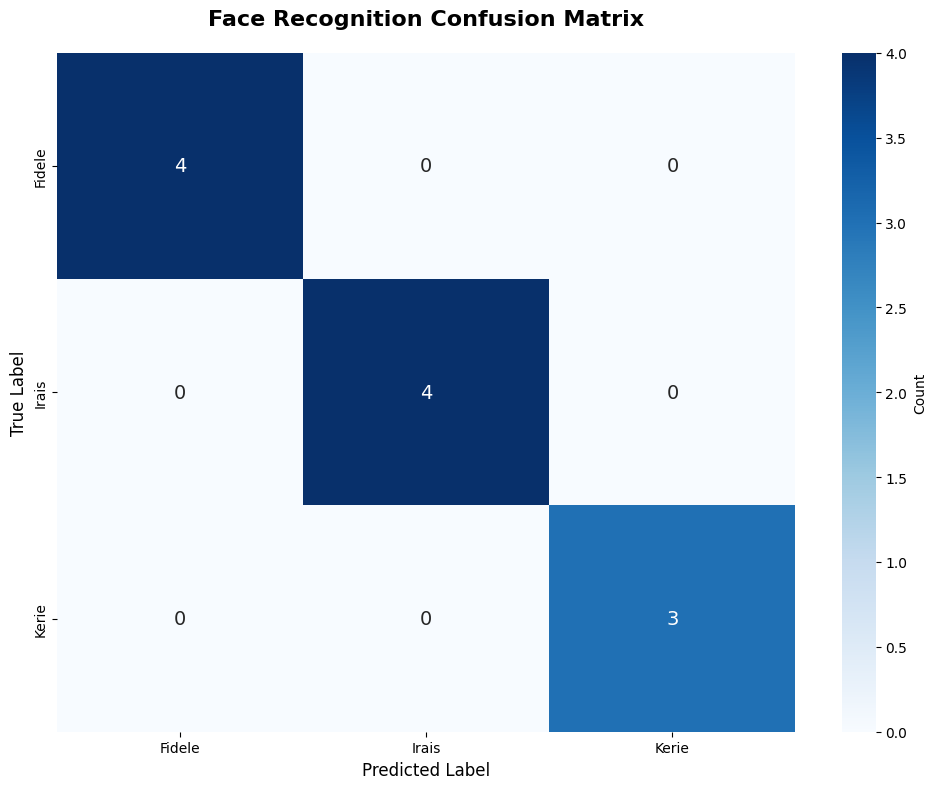

In [27]:
print("\n" + "="*70)
print("STEP 10: GENERATING CONFUSION MATRIX")
print("="*70)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Count'},
    annot_kws={'size': 14}
)
plt.title('Face Recognition Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()

# Save plot
cm_path = f"outputs/plots/confusion_matrix_{timestamp}.png"
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f"✓ Confusion matrix saved to: {cm_path}")
plt.show()

Feature Importances

✓ Feature importance plot saved to: outputs/plots/feature_importance_20251114_185819.png


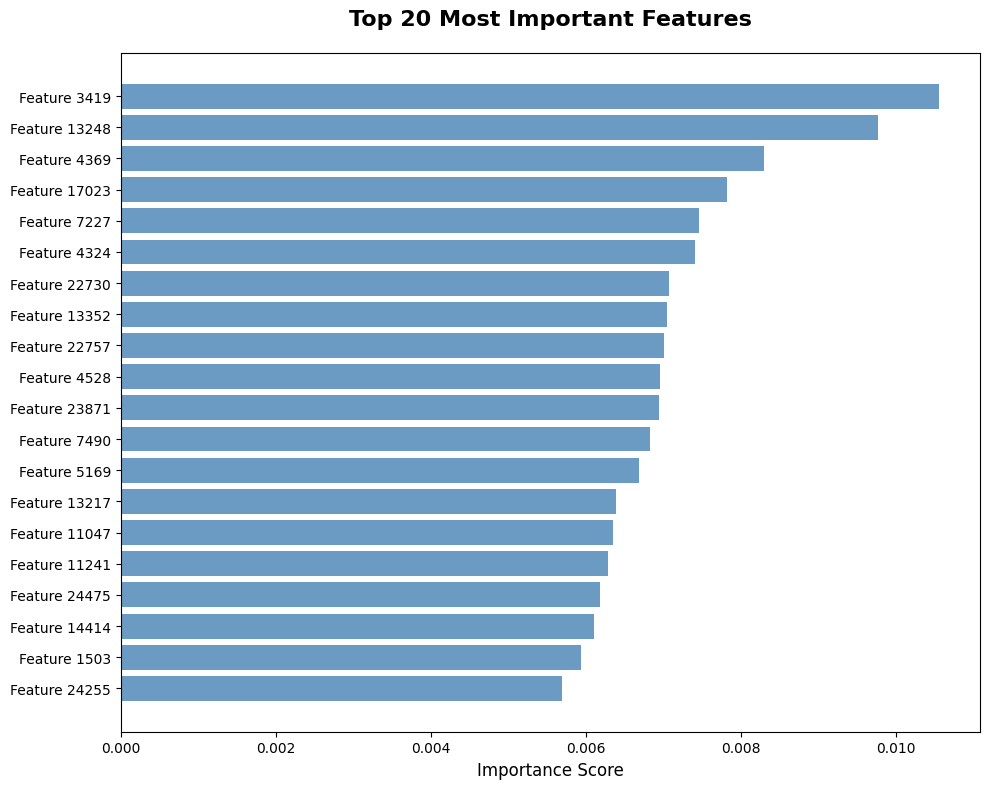

In [29]:
# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20

# Plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices], alpha=0.8, color='steelblue')
plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 20 Most Important Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()

# Save plot
fi_path = f"outputs/plots/feature_importance_{timestamp}.png"
plt.savefig(fi_path, dpi=300, bbox_inches='tight')
print(f"✓ Feature importance plot saved to: {fi_path}")
plt.show()


Saving Model Artifacts

In [30]:
# Save model
model_path = "models/face_recognition_model.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"✓ Model saved: {model_path}")

# Save scaler
scaler_path = "models/scaler.pkl"
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✓ Scaler saved: {scaler_path}")

# Save label encoder
encoder_path = "models/label_encoder.pkl"
with open(encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)
print(f"✓ Label encoder saved: {encoder_path}")

# Save model info
info_path = "models/model_info.txt"
with open(info_path, 'w') as f:
    f.write("="*70 + "\n")
    f.write("FACE RECOGNITION MODEL INFORMATION\n")
    f.write("="*70 + "\n\n")
    f.write(f"Created: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Model Type: Random Forest Classifier\n")
    f.write(f"Number of Trees: {model.n_estimators}\n")
    f.write(f"Max Depth: {model.max_depth}\n\n")
    f.write(f"Dataset:\n")
    f.write(f"  • Total images: {X.shape[0]}\n")
    f.write(f"  • Feature vector size: {X.shape[1]}\n")
    f.write(f"  • Training samples: {X_train.shape[0]}\n")
    f.write(f"  • Test samples: {X_test.shape[0]}\n\n")
    f.write(f"People recognized:\n")
    for idx, name in enumerate(label_encoder.classes_):
        f.write(f"  {idx+1}. {name}\n")
    f.write(f"\nPerformance:\n")
    f.write(f"  • Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)\n")
    f.write(f"  • Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)\n")
    f.write(f"  • F1-Score: {test_f1:.4f}\n")

print(f"✓ Model info saved: {info_path}")

✓ Model saved: models/face_recognition_model.pkl
✓ Scaler saved: models/scaler.pkl
✓ Label encoder saved: models/label_encoder.pkl
✓ Model info saved: models/model_info.txt
